# Etude sur Decision Tree Classifier, Hyperparamètres et Botanique. Deuxième partie.

# 1 Cross validation "Traditionnelle"

## Importation des librairies

Pour l'analyse des donnée, nous aurons besoin de la librairie "pandas" pour lire et manipuler les fichiers; la librairie "numpy" pour tous ceux qui est calcul mathématiques; et la librairie "matplotlib.pyplot" et "seaborn"pour la visualisation de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.datasets import load_iris
from sklearn import datasets, linear_model, model_selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix

## Chargement des données

In [2]:
iris = datasets.load_iris(as_frame=True)
iris["target"].value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

In [3]:
iris_mod = iris.frame.copy()
iris_mod

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
data = iris_mod.iloc[:,2:-1]

In [5]:
data

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [6]:
# X input data, t target data
X, t = iris_mod.iloc[:,2:-1].to_numpy(), iris_mod.iloc[:,-1].to_numpy()
X.shape, t.shape

((150, 2), (150,))

# visualisation des données

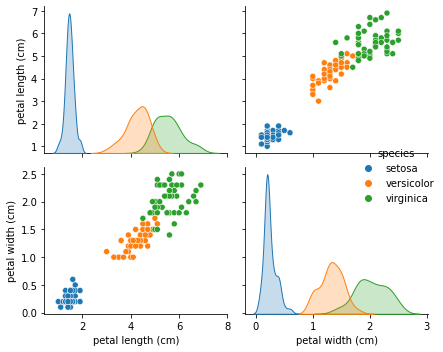

In [7]:
iris_target = iris.frame.copy()
iris_target['species'] = iris.target_names[iris.target]

sns.pairplot(iris_target, hue='species', vars=["petal length (cm)", "petal width (cm)"])

plt.tight_layout()
plt.show()

# echantilloage des données

Split data into 3 (train, validation, test)

First, I split data into 2 (train_val, test, 80:20)

In [8]:
X_train_val, X_test, t_train_val, t_test = train_test_split(X, t, test_size=0.2, stratify=t, random_state=42)

In [9]:
X_train_val.shape, X_test.shape, t_train_val.shape, t_test.shape

((120, 2), (30, 2), (120,), (30,))

Second, I split X_train_val, t_train_val into 2 (train, val, 80:20)

In [10]:
X_train, X_val, t_train, t_val = train_test_split(X_train_val, t_train_val, test_size=0.25, stratify=t_train_val, random_state=10)

In [11]:
X_train.shape, X_val.shape, t_train.shape, t_val.shape

((90, 2), (30, 2), (90,), (30,))

# affichage de la distribution des données

J'ai vérifié le proportion de données avant et après l'echantillonage.

In [12]:
iris_mod.target.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

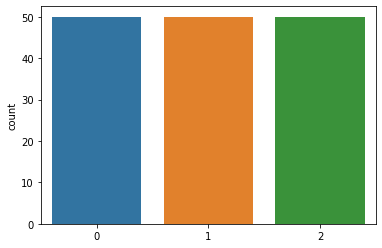

In [13]:
sns.countplot(x=t);

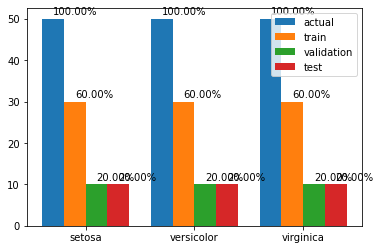

In [14]:
n, bins, patches = plt.hist([t, t_train, t_val, t_test], label=['actual', 'train', 'validation', 'test'], bins=np.arange(4)-0.5)
plt.legend(loc='upper right')
plt.xticks([0, 1, 2], ['setosa', 'versicolor', 'virginica'])
#n, bins, patches = plt.hist([y, y_train, y_test], label=['initial', 'jeu de train', 'jeu de test'], bins=np.arange(3) - 0.5)

total_0 = iris_mod.target.value_counts()[0]
total_1 = iris_mod.target.value_counts()[1]
total_2 = iris_mod.target.value_counts()[2]

for patch in patches:
    width_0, height_0 = patch[0].get_width(), patch[0].get_height()
    x_text_0, y_text_0 = patch[0].get_xy()
    width_1, height_1 = patch[1].get_width(), patch[1].get_height()
    x_text_1, y_text_1 = patch[1].get_xy()
    width_2, height_2 = patch[2].get_width(), patch[2].get_height()
    x_text_2, y_text_2 = patch[2].get_xy()
    
    plt.annotate("{:.2%}".format(height_0/total_0), xy = (x_text_0 + width_0/2 , y_text_0 + height_0 + 1))
    plt.annotate("{:.2%}".format(height_1/total_1), xy = (x_text_1 + width_1/2 , y_text_1 + height_1 + 1))
    plt.annotate("{:.2%}".format(height_2/total_2), xy = (x_text_2 + width_2/2 , y_text_2 + height_2 + 1))

plt.show()

Remarques:
    J'ai constaté que les données sont bien echantillonés.

# automatisation l'apprentissage du modèle avec CV "Traditionnelle"

automatisons maintenant l'apprentissage du modèle ! Pour cela, poursuivez votre Jupyter Notebook en implémentant une recherche par grille de la valeur optimale de l'hyperparamètre "max_depth".

NB il est à ce stade ++formellement prohibé++ d'utiliser les routines de scikit-learn pour effectuer la recherche par grille !

Evaluer et afficher ensuite les performances sur les jeux d'apprentissage, de validation et de test.

In [15]:
scores_train = {}
scores_val = {}
scores_test = {}
best_score = 0
best_max_depth = 1
for d in range(1,11):
    model = DecisionTreeClassifier(max_depth=d, random_state = 10)
    model.fit(X_train, t_train)
    
   # scores_train[d] = accuracy_score(X_train, predict(X_train))  
    scores_train[d] = model.score(X_train, t_train)   
    scores_val[d] = model.score(X_val, t_val)
    scores_test[d] = model.score(X_test, t_test)
    if scores_val[d] > best_score:
        best_score = scores_val[d]
        best_max_depth = d
        """print("best max_depth =", d)
        print("best_score:", best_score)
        print("")"""
    print("max_depth =", d)   
    print(f'Train score: {scores_train[d]}')
    print(f'Validation score: {scores_val[d]}')
    print(f'Test score: {scores_test[d]}')
    print("")
print("Resulta")
print("Le meilleur validation max_depth =", best_max_depth)
print("la meilleur validation score:", best_score)
best_model = DecisionTreeClassifier(max_depth=best_max_depth, random_state = 42)
print("best model", best_model)

max_depth = 1
Train score: 0.6666666666666666
Validation score: 0.6666666666666666
Test score: 0.6666666666666666

max_depth = 2
Train score: 0.9666666666666667
Validation score: 0.9666666666666667
Test score: 0.9333333333333333

max_depth = 3
Train score: 0.9888888888888889
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 4
Train score: 0.9888888888888889
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 5
Train score: 1.0
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 6
Train score: 1.0
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 7
Train score: 1.0
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 8
Train score: 1.0
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 9
Train score: 1.0
Validation score: 0.9666666666666667
Test score: 0.9666666666666667

max_depth = 10
Train score: 1.0
Validati

In [16]:
"""scores_train = {}
scores_val = {}
scores_test = {}
d = 1
for d in range(1,11):
    model = DecisionTreeClassifier(max_depth=d, random_state = 10)
    model.fit(X_train, t_train)
    scores_train[d] = model.score(X_train, t_train)
    scores_val[d] = model.score(X_val, t_val)
    scores_test[d] = model.score(X_test, t_test)
    print("max_depth =", d)
    print(f'Train score: {scores_train[d]}')
    print(f'Validation score: {scores_val[d]}')
    print(f'Test score: {scores_test[d]}')
    print("")
    """

'scores_train = {}\nscores_val = {}\nscores_test = {}\nd = 1\nfor d in range(1,11):\n    model = DecisionTreeClassifier(max_depth=d, random_state = 10)\n    model.fit(X_train, t_train)\n    scores_train[d] = model.score(X_train, t_train)\n    scores_val[d] = model.score(X_val, t_val)\n    scores_test[d] = model.score(X_test, t_test)\n    print("max_depth =", d)\n    print(f\'Train score: {scores_train[d]}\')\n    print(f\'Validation score: {scores_val[d]}\')\n    print(f\'Test score: {scores_test[d]}\')\n    print("")\n    '

dict_values([0.6666666666666666, 0.9333333333333333, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667])


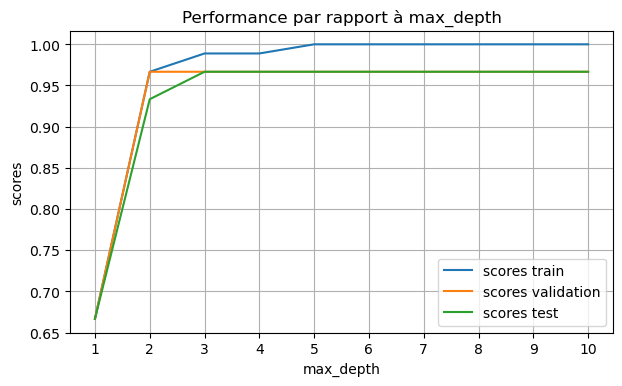

In [17]:
plt.figure(figsize=(7, 4), dpi=100)
p1=plt.plot(scores_train.values())
p2=plt.plot(scores_val.values())
p3=plt.plot(scores_test.values())
plt.title("Performance par rapport à max_depth")
plt.xlabel("max_depth")
plt.ylabel("scores")
plt.grid(True)
plt.xticks([0,1,2,3,4,5,6,7,8,9], list(scores_test.keys()))
plt.legend((p1[0], p2[0], p3[0]),("scores train", "scores validation", "scores test"))
print(scores_test.values())
plt.show()

## Matrix de confusion

In [18]:
#cm = confusion_matrix(y_true, y_pred)

In [19]:
best_model.fit(X_train, t_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [20]:
y_train_pred = best_model.predict(X_train_val)

In [21]:
cm = confusion_matrix(t_train_val, y_train_pred)
cm

array([[40,  0,  0],
       [ 0, 39,  1],
       [ 0,  3, 37]], dtype=int64)

In [22]:
print(cm.flatten())

[40  0  0  0 39  1  0  3 37]


In [23]:
cm.flatten()[0:3]

array([40,  0,  0], dtype=int64)

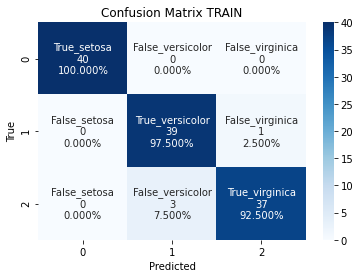

In [24]:
ax= plt.subplot()

group_names = ['True_setosa','False_versicolor','False_virginica','False_setosa','True_versicolor','False_virginica','False_setosa','False_versicolor','True_virginica']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages1 = ["{0:.3%}".format(value) for value in cm.flatten()[0:3]/np.sum(cm.flatten()[0:3])]
group_percentages2 = ["{0:.3%}".format(value) for value in cm.flatten()[3:6]/np.sum(cm.flatten()[3:6])]
group_percentages3 = ["{0:.3%}".format(value) for value in cm.flatten()[6:]/np.sum(cm.flatten()[6:])]
group_percentages = np.append(group_percentages1, group_percentages2)
group_percentages = np.append(group_percentages, group_percentages3).tolist()
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip (group_names, group_counts, group_percentages)]
labels = np.array(labels).reshape(3,3)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('True') 
ax.set_title('Confusion Matrix TRAIN') 

plt.show()

In [1]:
#print(cm.flatten())

#tn, fp, fn, tp = cm.flatten()